In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
data = pd.read_csv("data.csv") 
data.head()

,StudentID,StudyHours,Attendance,HomeworkScores,ProjectScores,MidtermScores,ExtracurricularActivities,StudyEnvironment,OnlineResourcesUsage
0,1,17.5,99.0,64.9,60.9,67.6,1.0,1.0,1
1,2,14.3,94.2,72.8,71.4,77.6,1.0,NaN,4
2,3,18.2,85.6,63.1,75.9,78.2,2.0,2.0,7
3,4,22.6,78.5,70.4,98.9,83.7,2.0,2.0,1
4,5,13.8,92.0,50.0,85.6,61.6,3.0,2.0,1


In [2]:
data.fillna(data.mean(), inplace=True)
label_encoder = LabelEncoder()
data['StudyEnvironment'] = label_encoder.fit_transform(data['StudyEnvironment'].astype(str))
scaler = StandardScaler()
numeric_columns = ['StudyHours', 'Attendance', 'HomeworkScores', 'ProjectScores', 'MidtermScores', 'ExtracurricularActivities', 'OnlineResourcesUsage']
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
data.head()

,StudentID,StudyHours,Attendance,HomeworkScores,ProjectScores,MidtermScores,ExtracurricularActivities,StudyEnvironment,OnlineResourcesUsage
0,1,0.494692,1.459518,-0.752602,-1.906543,-0.854356,-0.771430,0,-1.598343
1,2,-0.170077,0.945407,-0.167329,-0.848461,0.020247,-0.771430,1,-0.556851
2,3,0.640110,0.024292,-0.885955,-0.394997,0.072723,0.076295,2,0.484641
3,4,1.554168,-0.736164,-0.345133,1.922707,0.553755,0.076295,2,-1.598343
4,5,-0.273947,0.709773,-1.856471,0.582469,-1.379118,0.924021,2,-1.598343


In [ ]:
from scipy.spatial.distance import cdist
def weighted_distance(X, Y, weights):
    return np.sqrt(np.sum(weights * (X - Y) ** 2, axis=1))
weights = np.array([1.5, 1, 0.5, 1.2, 1, 0.8, 1.1]) 

In [5]:
!pip install kneed


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from kneed import KneeLocator
sse = []
silhouette_scores = []
davies_bouldin_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data[numeric_columns])
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data[numeric_columns], kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(data[numeric_columns], kmeans.labels_))
kneedle = KneeLocator(range(2, 11), sse, curve="convex", direction="decreasing")
optimal_k_elbow = kneedle.elbow
print("Optimal K (Elbow):", optimal_k_elbow)
optimal_k_silhouette = np.argmax(silhouette_scores) + 2
print("Optimal K (Silhouette):", optimal_k_silhouette)
optimal_k_davies_bouldin = np.argmin(davies_bouldin_scores) + 2
print("Optimal K (Davies-Bouldin):", optimal_k_davies_bouldin)

Optimal K (Elbow): 6
Optimal K (Silhouette): 10
Optimal K (Davies-Bouldin): 10


In [5]:
def weighted_distance(u, v, weights):
    return np.sqrt(np.sum(weights * (u - v) ** 2))
from sklearn.base import BaseEstimator, ClusterMixin
from scipy.spatial.distance import cdist
class CustomKMeans(BaseEstimator, ClusterMixin):
    def __init__(self, n_clusters=3, max_iter=300, tol=1e-4, weights=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.weights = weights if weights is not None else np.ones(data.shape[1] - 1)
    def fit(self, X):
        X = np.array(X) 
        self.centroids = X[np.random.choice(range(X.shape[0]), self.n_clusters, replace=False)]
        for i in range(self.max_iter):
            labels = np.argmin(cdist(X, self.centroids, lambda u, v: weighted_distance(u, v, self.weights)), axis=1)
            new_centroids = np.array([X[labels == j].mean(axis=0) for j in range(self.n_clusters)])
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids
        self.labels_ = labels
        return self
optimal_k = optimal_k_silhouette 
custom_kmeans = CustomKMeans(n_clusters=optimal_k, weights=weights)
custom_kmeans.fit(data[numeric_columns].values) 
data['Cluster'] = custom_kmeans.labels_

In [6]:
for cluster in range(optimal_k):
    cluster_data = data[data['Cluster'] == cluster]
    print(f"Cluster {cluster} Summary:")
    print(cluster_data.describe())

Cluster 0 Summary:
        StudentID  StudyHours  Attendance  HomeworkScores  ProjectScores  \
count  130.000000  130.000000  130.000000      130.000000     130.000000   
mean   500.007692   -0.353368   -0.295215        0.141492      -1.044497   
std    294.780131    0.661720    0.940751        1.025048       0.601436   
min      2.000000   -2.018966   -3.113926       -1.856471      -1.997236   
25%    235.250000   -0.803685   -0.811138       -0.609988      -1.430406   
50%    524.000000   -0.263560   -0.254185        0.247548      -1.014731   
75%    749.250000    0.203856    0.350966        0.914315      -0.578902   
max    995.000000    0.889399    1.566624        1.847788       0.411161   

       MidtermScores  ExtracurricularActivities  StudyEnvironment  \
count     130.000000                 130.000000        130.000000   
mean        0.454118                  -0.177892          1.100000   
std         0.719930                   0.965951          1.199806   
min        -1.046769

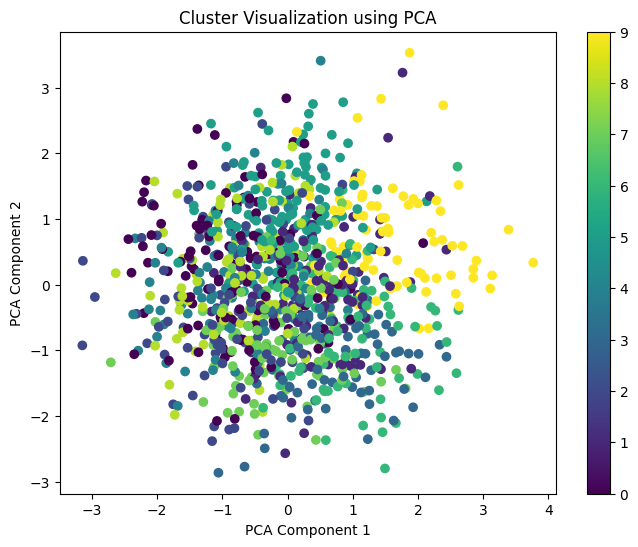

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data[numeric_columns])
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=data['Cluster'], cmap='viridis')
plt.colorbar()
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Cluster Visualization using PCA")
plt.show()